# Imports

In [1]:
# import os
# import torch
# import time
import cv2
import numpy as np
# import pandas as pd
from PIL import Image

# import torch.nn as nn
# from tqdm import tqdm
# import seaborn as sns
# import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
# from collections import Counter
# from torch.utils.data import Subset
# from torchvision import datasets 
from torchvision import transforms 
# from torch.utils.data import DataLoader, Subset, random_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


## UTILS

In [2]:
def show_image_and_histogram(img, title_image="Image", title_hist="Histogram", bins=256):
    # plotar imagem de um lado e do outro o histograma
    plt.figure(figsize=(15, 5))

    # Adicionar a imagem
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title(title_image)
    plt.axis("off")

    # Adicionar o histograma da imagem
    plt.subplot(1, 2, 2)
    plt.hist(np.array(img).ravel(), bins=bins, color="black")
    plt.title(title_hist)
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

Imagem Original

In [3]:
file_cnv = 'exemples\CNV-1016042-1.jpeg'

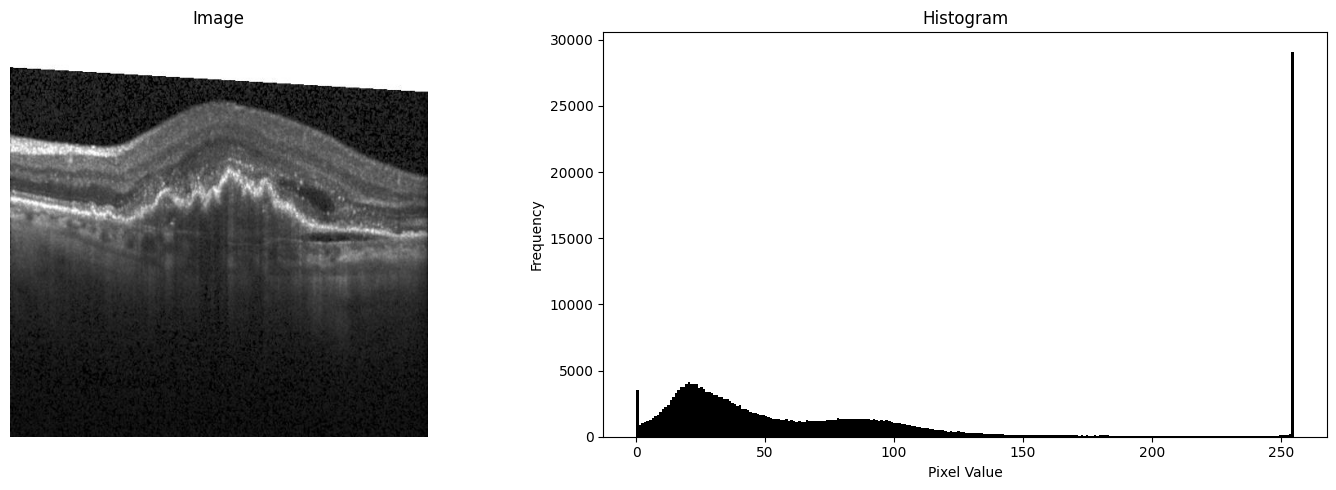

In [4]:
img = Image.open(file_cnv)
# img
show_image_and_histogram(img, title_image="Image", title_hist="Histogram", bins=256)

In [5]:
img.size

(512, 496)

config

In [6]:
mean, std = 0.18484567, 0.15903676
input_channels= 1

classe = 'cnv'
path_to_save = f'resultados\\{classe}'

Resize

In [ ]:
resize = transforms.Resize((150, 150))

T = transforms.Compose([transforms.Resize((150, 150))])
# salvar imagem
T(img).save(f'{path_to_save}\\resize.jpeg')
# T(img)
show_image_and_histogram(T(img), title_image="Image", title_hist="Histogram", bins=256)


Crop

In [ ]:
T = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128))
    ])
T(img).save(f'{path_to_save}\\crop.jpeg')

show_image_and_histogram(T(img), title_image="Image", title_hist="Histogram", bins=256)

Tensor

In [ ]:
T = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor()
    ])
T(img)


Normalize

In [ ]:
T = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean] * input_channels, std=[std] * input_channels),
    ])
T(img)


## Observação
Com essa normalização(proposta pelo artigo) os valores dos pixels ficam muito discrepantes(intervalos muito grandes e diferentes para cada imagem).

Isso talvez prejudique tanto no treinamento do modelo quanto na segmentação(?)

## Proposta
Não utilizar normalização padrão. Quando se converte para tensor(ao se passar uma imagem PIL ou um ndarray), os pixels da imagem já ficarão normalizados entre 0 e 1(tá na documentação do metodo ToTensor do transformers). Isso facilita na convergencia do modelo, amenizando a sensibilidade à escala dos dados.
Não há risco de perda de informação ao se utilizar a escala [0., 1.] pois no python não há limite de bytes para um número, entao ele pode ser tão especifico(casas decimais) quanto necessário e o ToTensor lida com isso utilizando casas decimais o suficiente. 

In [ ]:
temp = T(Image.open(f'exemples\DME-9583225-1.jpeg'))

print(temp.shape)
print((float(temp.min()), float(temp.max())))
print((float(temp.mean()), float(temp.std())))

In [ ]:
temp = T(Image.open(f'exemples\DRUSEN-9800172-2.jpeg'))

print(temp.shape)
print((float(temp.min()), float(temp.max())))
print((float(temp.mean()), float(temp.std())))

In [ ]:
temp = T(Image.open(f'exemples\\NORMAL-4872585-1.jpeg'))

print(temp.shape)
print((float(temp.min()), float(temp.max())))
print((float(temp.mean()), float(temp.std())))

# Preprocessing 

Etapas para pré-processamento de dados:

1.
Leia arquivos do diretório.

2.
Aplique o redimensionamento de cada imagem para 150 × 150 pixels.

3.
Aplique a operação CentreCrop com dimensões finais de 128 × 128 pixels a cada imagem.

4.
Converta a imagem para o tipo de dados tensor para compatibilidade com o modelo.

5.
Normalize a imagem subtraindo a média de cada valor de pixel e dividindo o resultado pelo desvio padrão usando a transformação padrão.



In [ ]:
T = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean] * input_channels, std=[std] * input_channels),
    ])
T(img)


## Imagem com Filtro da Mediana

In [ ]:
def median_filter(image, ksize: int = 5) -> Image:
    return Image.fromarray(cv2.medianBlur(np.array(image), ksize=ksize))


ksize = 5

T = transforms.Compose([
    # transforms.Lambda(lambda x: median_filter(x, ksize=ksize)), # mediana
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[mean] * input_channels, std=[std] * input_channels),
    ])

# salvar imagem ao aplicar apenas a mediana
median_filter(img, ksize=ksize).save(f'{path_to_save}\\median.jpeg')

T(img)


### Imagem

Antes e depois do filtro da mediana

In [ ]:
ksizes = [3, 5, 7, 9, 11, 13]

for k in ksizes:
    show_image_and_histogram(median_filter(img, ksize=k), title_image=f"Median Filter (k={k})", title_hist="Histogram", bins=256)





## Aprimoramento

Etapas para aprimoramento de imagem:

1. Leia arquivos do diretório.

2. Aplique filtro de mediana para suavizar.

3. Converta para escala de cinza para operações futuras.

4. Aplique CLAHE sobre a imagem para melhorar o contraste baixo.

5. Limiar de imagem por limites de corte de limiar adequados.

6. Remova ruídos e quebras adicionais na estrutura por meio de operação de morfologia.

7. Extraia contornos da saída acima para extrair bordas da camada da retina (as outras técnicas de detecção de bordas não foram úteis, conforme discutido).

8. Desenhe contornos na imagem original para permitir bordas e estruturas de camadas.

9. Aplique outras transformações como na etapa anterior, incluindo redimensionamento, corte central e normalização.



### CLAHE
CLAHE (Contrast Limited Adaptive Histogram Equalization) é um algoritmo de equalização de histograma adaptativo que foi projetado para melhorar o contraste de uma imagem, especialmente em áreas com baixo contraste, sem saturar a imagem em áreas com alto contraste.

#### Como Funciona o CLAHE?

- Enquanto o processo tradicional de equalização de histograma aplica uma transformação global ao histograma da imagem inteira (ou seja, aumenta o contraste globalmente), o CLAHE divide a imagem em pequenas regiões chamadas blocos ou tiles e realiza a equalização de histograma de forma local (adaptativa), ajustando o contraste em cada bloco individualmente.
Limitação do Contraste (Limite de Contraste):

- Um dos problemas com a equalização de histograma tradicional é que ela pode criar artefatos em áreas de alta intensidade, especialmente em imagens que já têm um bom contraste. Para evitar isso, o CLAHE aplica um limite de contraste: ele restringe a amplificação do contraste nas áreas de alta intensidade, evitando que as regiões com alto contraste se tornem excessivamente saturadas.
Operação por Blocos:

- A imagem é dividida em pequenos blocos (blocos quadrados ou retangulares) e, dentro de cada bloco, a equalização de histograma é realizada. Após a equalização local, os blocos são combinados para formar a imagem final. Como o processo é feito localmente, ele adapta-se melhor a variações locais de iluminação na imagem.
Passos do Algoritmo CLAHE
Divisão da Imagem: A imagem é dividida em blocos (tiles). Cada bloco é processado individualmente.
Equalização Local: Para cada bloco, é realizada uma equalização de histograma local, ajustando o brilho e contraste com base na distribuição dos pixels dentro do bloco.
Limitação de Contraste: Durante a equalização, o contraste máximo é limitado para evitar que as áreas de alta intensidade fiquem excessivamente saturadas.
Interpolação: Após o processamento de cada bloco, a borda entre os blocos é suavizada para garantir uma transição suave entre os diferentes blocos.
Vantagens do CLAHE
Melhoria do Contraste Local: O CLAHE pode melhorar o contraste em áreas específicas de uma imagem, o que é especialmente útil em imagens com iluminação não uniforme, como imagens médicas (por exemplo, radiografias ou imagens de retina).
Evita Saturação: Como ele limita o contraste, o CLAHE evita a saturação da imagem, ao contrário da equalização de histograma global, que pode resultar em distorções nas áreas de alta intensidade.



#### Observação
O artigo não fala sobre os parametros(clipLimit e tileGridSize) utilizados no Algoritmo CLAHE.

In [ ]:
def clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return Image.fromarray(clahe.apply(np.array(image)))

clip_limit = 2.0
tile_grid_size = (8, 8)

# salvar imagem ao aplicar com o clahe
temp = clahe(img, clip_limit=clip_limit, tile_grid_size=tile_grid_size)
temp.save(f'{path_to_save}\\clahe.jpeg')

show_image_and_histogram(temp, title_image="CLAHE", title_hist="Histogram", bins=256)


### Limiar de imagem por limites de corte de limiar adequados
#### Observação
O artigo não fala qual algoritmo utilizado para a busca de limiar

In [ ]:
def otsu(image):
    threshold, otsu = cv2.threshold(np.array(image), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return Image.fromarray(otsu)


otsu(img).save(f'{path_to_save}\\otsu.jpeg')
# otsu_threshold(img)
show_image_and_histogram(otsu(img), title_image="Otsu Threshold", title_hist="Histogram", bins=256)

In [ ]:
def iterative_threshold(image, delta=0.1):
    image = np.array(image)
    threshold = np.mean(image)
    while True:
        group1, group2 = image[image > threshold], image[image <= threshold]
        m1 = np.mean(group1) if len(group1) > 0 else 0
        m2 = np.mean(group2) if len(group2) > 0 else 0
        new_threshold = (m1 + m2) / 2
        if abs(threshold - new_threshold) < delta:
            return new_threshold
        threshold = new_threshold

# segmentar a imagem com o threshold obtido pelo método iterativo
threshold = int(iterative_threshold(img, delta=0.1))
thresholded = Image.fromarray((np.array(img) > threshold).astype(np.uint8) * 255  )
thresholded.save(f'{path_to_save}\\iterative.jpeg')

show_image_and_histogram(thresholded, title_image="Iterative Threshold", title_hist="Histogram", bins=256)

### Operações de Morfologia

Remova ruídos e quebras adicionais na estrutura por meio de operação de morfologia

## Observação
O artigo fala sobre remover ruídos e quebras utilizando operação(no singular) de **morfologia**, mas não diz qual exatamente. 
Suponho que seja a operação de ***Fechamento***;

O artigo não menciona que tipo(circular, retangular, ...) de **elemento estruturante** nem o tamanho do kernel(3x3, 5x5, ...) que foi utilizado.


In [ ]:
kernel_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))  # elemento estruturante
print(kernel)

image = np.array(img)
eroded = cv2.erode(image, kernel, iterations=1)
dilated = cv2.dilate(image, kernel, iterations=1)
opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
# tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
# blackhat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)


images = [image, eroded, dilated, opened, closed, gradient]
segs = [ otsu(Image.fromarray(i)) for i in images]


titulos = ["Original", "Eroded", "Dilated", "Opened", "Closed", "Gradient"]
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    axs[i // 3, i % 3].imshow(segs[i], cmap="gray")
    axs[i // 3, i % 3].set_title(titulos[i])
    axs[i // 3, i % 3].axis("off")
plt.tight_layout()
plt.show()

### Extraia contornos da saída acima para extrair bordas da camada da retina

In [ ]:
# extrair contornos da imagem com morfologia de fechamento
contours, _ = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# desenhar contornos na imagem
contour_image = cv2.drawContours(np.zeros_like(img), contours, -1, 255, 1)
# contour_image = Image.fromarray(contour_image)

show_image_and_histogram(Image.fromarray(contour_image), title_image="Contours", title_hist="Histogram", bins=256)

#### Processo de Aprimoramento completo

##### com fechamento

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Leia arquivos do diretório
image = cv2.imread(file_cnv)
original = image.copy()  # Guardar cópia da imagem original

# 2. Aplique filtro de mediana para suavizar
median_filtered = cv2.medianBlur(image, ksize=5)

# 3. Converta para escala de cinza
gray = cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY)

# 4. Aplique CLAHE (Equalização Adaptativa do Histograma)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# 5. Aplique limiarização (Threshold)
_, thresholded = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 6. Remova ruídos com morfologia
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
cleaned = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel, iterations=1)
# cleaned = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=1)

# 7. Extraia contornos
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 8. Desenhe contornos na imagem original
contour_image = cv2.drawContours(original, contours, -1, (0, 255, 0), 2)

# 9. (Opcional) Redimensione, corte ou normalize conforme necessário
resized = cv2.resize(contour_image, (150, 150))  # Exemplo de redimensionamento

# Mostrar resultados
titles = ["Original", "Median Filter", "CLAHE", "Segmented", "Contours"]
images = [image, median_filtered, enhanced, cleaned, contour_image]

plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    if i < 4:
        plt.imshow(images[i], cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


##### com abertura

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Leia arquivos do diretório
image = cv2.imread(file_cnv)
original = image.copy()  # Guardar cópia da imagem original

# 2. Aplique filtro de mediana para suavizar
median_filtered = cv2.medianBlur(image, ksize=5)

# 3. Converta para escala de cinza
gray = cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY)

# 4. Aplique CLAHE (Equalização Adaptativa do Histograma)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# 5. Aplique limiarização (Threshold)
_, thresholded = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 6. Remova ruídos com morfologia
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# cleaned = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel, iterations=1)
cleaned = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=1)

# 7. Extraia contornos
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 8. Desenhe contornos na imagem original
contour_image = cv2.drawContours(original, contours, -1, (0, 255, 0), 2)

# 9. (Opcional) Redimensione, corte ou normalize conforme necessário
resized = cv2.resize(contour_image, (150, 150))  # Exemplo de redimensionamento

# Mostrar resultados
titles = ["Original", "Median Filter", "CLAHE", "Segmented", "Contours"]
images = [image, median_filtered, enhanced, cleaned, contour_image]

plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    if i < 4:
        plt.imshow(images[i], cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


## Aprimoramento(com transformers)

In [ ]:
# img = cv2.imread(file_cnv, cv2.IMREAD_GRAYSCALE)
img = Image.open(file_cnv)
def enhance_image(img):
    img = np.array(img)
    img = cv2.medianBlur(img, 5)    # filtro de mediana
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
    img = clahe.apply(img)
    
    # segmentar a imagem com o threshold de Otsu
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)
    return Image.fromarray(img)

T = transforms.Compose([
    transforms.Lambda(lambda x: enhance_image(x)),
    
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean] * input_channels, std=[std] * input_channels),
    ])
T(img)
